### 线性回归
算法推导过程中已经给出了求解方法，基于最小二乘法直接求解，但这并不是机器学习的思想，由此引入了梯度下降方法。该实验重点理解梯度下降每一步流程与实验对比分析

#### 主要内容
- 线性回归方程实现
- 梯度下降效果
- 对比不同梯度下降策略
- 建模曲线分析
- 过拟合与欠拟合
- 正则化作用
- 提前停止策略

In [1]:
%matplotlib inline

import os
import warnings

from matplotlib import pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#### 回归方程：
当做是一个巧合就可以了，机器学习中核心的思想是迭代更新
![回归方程](../images/linear.png)

In [2]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

(0.0, 2.0, 0.0, 15.0)

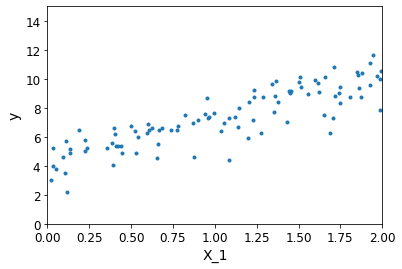

In [3]:
plt.plot(X, y, '.')
plt.xlabel('X_1')
plt.ylabel('y')
plt.axis([0,2, 0, 15])

#### 参数直接求解法

In [4]:
X_b = np.c_[np.ones((100, 1)), X]
# np.linalg.inv求逆
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

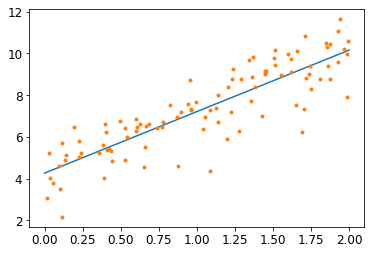

In [6]:
plt.plot(X_new, y_predict, '-')
plt.plot(X, y, '.')

#### sklearn API文档：
https://scikit-learn.org/stable/modules/classes.html



#### 工具包实现

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, y)
print(reg.coef_)
print(reg.intercept_)

[[2.94429259]]
[4.26157435]


### 梯度下降
![梯度下降原理](../images/gradient.png)

- 问题：步长太小
![步长太小](../images/gradient_step_low.png)

- 问题：步长太大
![步长太大](../images/gradient_step_high.png)

- 遇到的问题
![收敛的问题](../images/5.png)

- 标准化的作用
![标准化的作用](../images/6.png)

- 批量梯度下降
![批量梯度下降](../images/7.png)

In [8]:
eta = 0.1  # 学习率
n_iterations = 100  # 迭代次数
m = 100
theta = np.random.randn(2, 1)
for i in range(n_iterations):
    gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradient


In [9]:
X_new_b.dot(theta)

array([[ 4.14812893],
       [10.21983819]])

#### 学习率对结果的影响

In [10]:
theta_path_bgd = []
def plot_gradient_descent(theta, eta, theta_path=None):
    n_iterations = 1000  # 迭代次数
    m = len(X_b)
    plt.plot(X, y, 'b.')
    for i in range(n_iterations):
        y_predict = X_new_b.dot(theta)
        plt.plot(X_new, y_predict, 'r-')
        gradient = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradient
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel('X_1')
    plt.axis([0, 2, 0, 15])
    plt.title('eta={}'.format(eta))

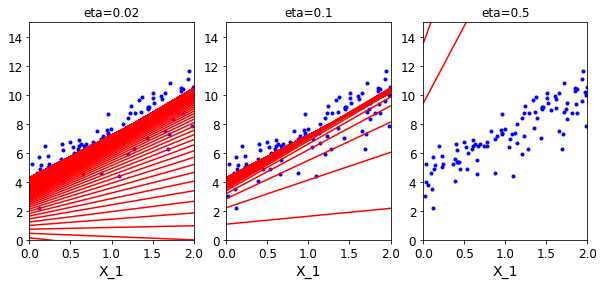

In [11]:
theta = np.random.randn(2, 1)
plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.subplot(132)
plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)

#### 随机梯度下降

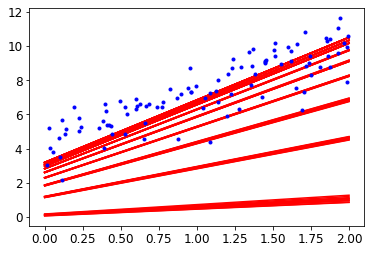

In [12]:
theta_path_sgd = []
m = len(X_b)
n_epochs = 50

t0 = 5
t1 = 50

theta = np.random.randn(2,1)

def learning_schedule(t):
    return t0/(t1+t)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch < 10 and i < 10:  # 只展示部分，因全部展示，效果不明显
            y_predict = X_new_b.dot(theta)
            plt.plot(X_new, y_predict, 'r-')
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradient = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(n_epochs*m+i)
        theta = theta - eta * gradient
        theta_path_sgd.append(theta)
plt.plot(X, y, 'b.')

#### 小批量梯度下降

In [13]:
theta_path_mgd=[]
n_epochs = 50
minibatch = 16
theta = np.random.randn(2,1)
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)
np.random.seed(42)
t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)  # 数据打乱/洗牌
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch):
        t += 1
        xi = X_b_shuffled[i:i+minibatch]
        yi = y_shuffled[i:i+minibatch]
        gradient = 2 / minibatch * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradient
        theta_path_mgd.append(theta)

#### 3种策略的对比实验

In [14]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

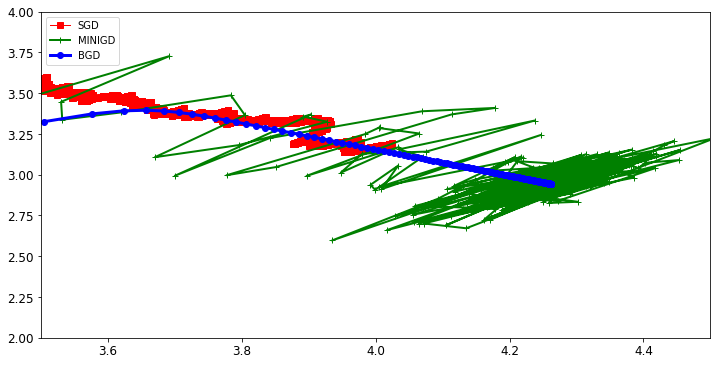

In [15]:
plt.figure(figsize=(12,6))
plt.plot(theta_path_sgd[:,0],theta_path_sgd[:,1],'r-s',linewidth=1,label='SGD')
plt.plot(theta_path_mgd[:,0],theta_path_mgd[:,1],'g-+',linewidth=2,label='MINIGD')
plt.plot(theta_path_bgd[:,0],theta_path_bgd[:,1],'b-o',linewidth=3,label='BGD')
plt.legend(loc='upper left')
plt.axis([3.5,4.5,2.0,4.0])
plt.show()

从上图可知， 全量梯度下降效果好，但是十分耗时。
实际当中用小批量梯度下降较多，一般情况下选择batch数量应当越大越好

### 多项式回归

多项式特征可以理解为对现有特征的乘积，比如现在有特征A，特征B，特征C，那就可以得到$A^2, A*B, A*C, B^2, B*C$以及$C^2$. 新生成的这些变量即原有变量的有机组合，换句话说，当两个变量各自与y的关系并不强时候，把它们结合成为一个新的变量可能更会容易体现出它们与y的关系.  

构造多项式特征: sklearn.preprocessing.PolynomialFeatures
- PolynomialFeatures 这个类有 3 个参数：
    - degree：控制多项式的次数；
    - interaction_only：默认为 False，如果指定为 True，那么就不会有特征自己和自己结合的项（没有平方项）；
    - include_bias：默认为 True 。如果为 True 的话，那么结果中就会有 0 次幂项，即全为 1 这一列

- Pipeline: 管道，将一个或多个Transformer和Estimator(最后一步)组合起来形成一个机器学习工作流 
    - Pipeline 的中间过程由scikit-learn相适配的转换器（transformer）构成，最后一步是一个estimator
        - transformer(转换器): 数据预处理过程，包括特征标准化、均一化、PCA降维、LDA降维等
        - estimator(评估器或适配器): 通常是使用的算法，如线性回归、逻辑回归、SVM等

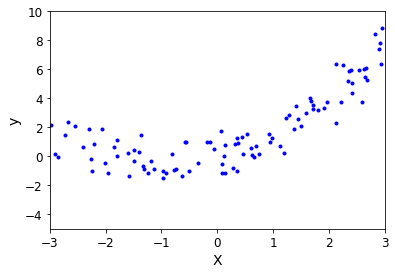

In [16]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + np.random.randn(m ,1)
plt.plot(X, y, 'b.')
plt.xlabel('X')
plt.ylabel('y')
plt.axis([-3, 3, -5, 10])
plt.show()

In [17]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)  # 构造多项式特征
X_poly = poly_features.fit_transform(X)

In [19]:
X_poly[0]

array([2.38942838, 5.709368  ])

In [22]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.coef_)
print(lin_reg.intercept_)

[[0.95038538 0.52577032]]
[-0.0264767]


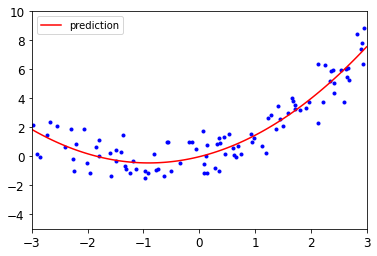

In [24]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', label='prediction')
plt.axis([-3, 3, -5, 10])
plt.legend()
plt.show()

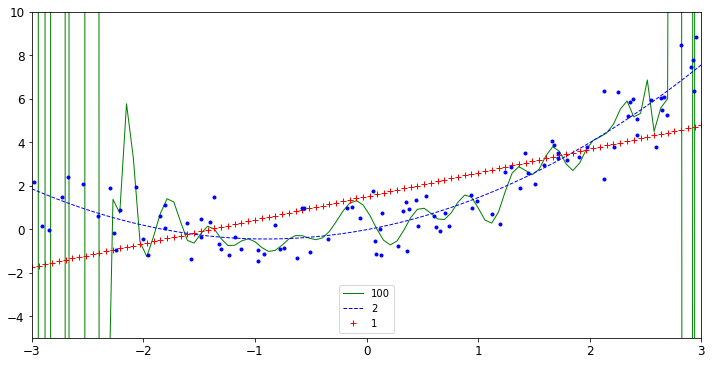

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
plt.figure(figsize=(12, 6))
for style, width, degree in (('g-',1, 100), ('b--', 1, 2), ('r+', 1, 1) ):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    std = StandardScaler()
    estimator = LinearRegression()
    pipe_lin = Pipeline(
        [
            ('poly_features', poly_features),  # 构造多项式特征
            ('StandardScaler', std),  # 标准化
            ('LinearRegression', estimator)  #线性回归预估器
        ]
    )
    pipe_lin.fit(X, y)
    y_new_2 = pipe_lin.predict(X_new)
    plt.plot(X_new, y_new_2, style, label=str(degree), linewidth=width)
plt.axis([-3, 3, -5, 10])
plt.plot(X, y, 'b.')
plt.legend()

由图可知，特征变换的越复杂，得到的结果过拟合风险越高，不建议模型做的特别复杂

### 样本数量对结果的影响

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    train_errors, test_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict[:m]))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
    plt.plot(np.sqrt(train_errors), 'r+-', linewidth=2, label='train_error')
    plt.plot(np.sqrt(test_errors), 'b-', linewidth=3, label='test_error')
    plt.xlabel('Trainsing set size')
    plt.ylabel('RMSE')
    plt.legend()

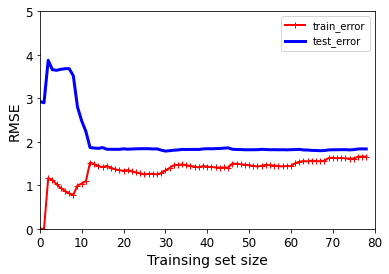

In [65]:
estimator = LinearRegression()
plt.axis([0, 80, 0, 5])
plot_learning_curves(estimator, X, y)

由图可知，数据量越少，训练集的效果会越好(均方误差越小)，但是实际测试效果很一般。实际做模型的时候需要参考测试集和验证集的效果。

#### 多项式回归的过拟合风险

(0.0, 80.0, 0.0, 10.0)

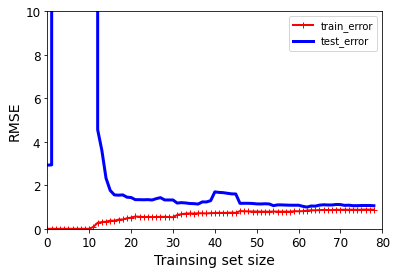

In [69]:
pipe_lin = Pipeline(
    [
        ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
        ('LinearRegression', LinearRegression())
    ]
)

plot_learning_curves(pipe_lin, X, y)
plt.axis([0, 80, 0, 10])

越复杂越过拟合

### 正则化
对权重参数进行惩罚，让权重参数尽可能平滑一些，有两种不同的方法来进行正则化惩罚:
![title](../images/9.png)

#### 岭回归

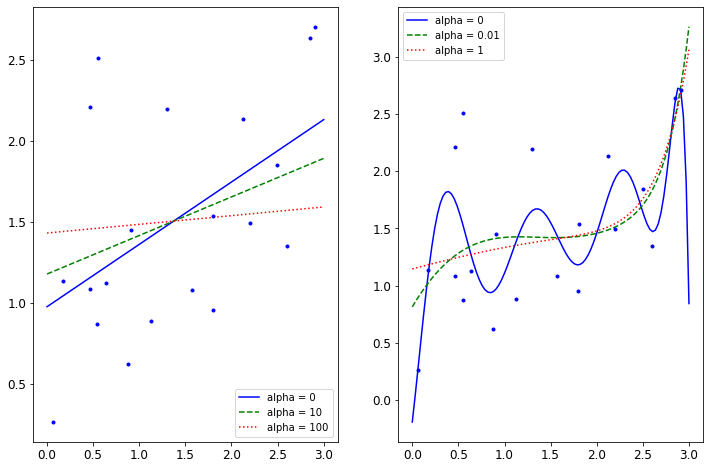

In [88]:
from sklearn.linear_model import Ridge
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 0.5 * X + np.random.randn(m, 1)/1.5 + 1
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_cls, polynomial, alphas, **model_kwargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        estimator = model_cls(alpha, **model_kwargs)
        if polynomial:
            estimator = Pipeline(
                [
                    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)), 
                    ('StandardScaler', StandardScaler()),
                    ('LinearRegression', estimator)
                ]
            )
        estimator.fit(X, y)
        y_new_regul = estimator.predict(X_new)
        plt.plot(X_new, y_new_regul, style, label='alpha = {}'.format(alpha))
    plt.plot(X, y, 'b.')
    plt.legend()
plt.figure(figsize=(12, 8))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100))
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 0.01, 1))


惩罚力度越大，alpha值越大的时候，得到的决策方程越平稳。
![title](../images/9.png)

#### Lasso回归

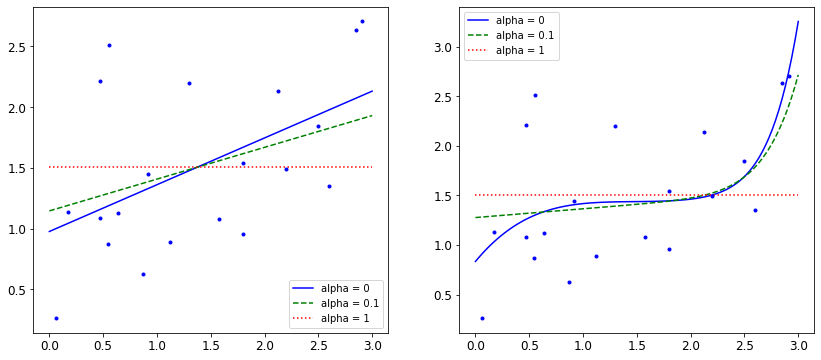

In [80]:
from sklearn.linear_model import Lasso
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1))
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 0.1, 1))
